In [9]:
import typing as tp
import pandas as pd
import numpy as np
import random
import pickle
import torch

from tqdm import tqdm
from pathlib import Path
#from common import * # this line comes from WildMe, not sure which common library this is referring to

### Load precomputed list of matches

We have generated a match list on the MiewID Beluga test dataset and stored it at ```/srv/transparency/wildbook_prototype/data/matches```.

In [10]:
def unpickler(fp: Path | str):
    if isinstance(fp, str):
        fp = Path(fp)

    try:
        with open(fp, "r") as f:
            return pickle.load(f)
    except UnicodeDecodeError:
        with open(fp, "rb") as f:
            return pickle.load(f)

match_path = '/srv/transparency/wildbook_prototype/data/matches'
print([p for p in Path(match_path).glob("*")])

### df_test stores the dataframe containing metadata for the N instances of the test dataset
df_test = unpickler(Path(match_path, "df_test.pkl"))

### test_dataset stores the actual MiewIDDataset object used during evaluation
test_dataset = unpickler(Path(match_path, "test_dataset.pkl"))

### match_results stores 4 tensors:
###     match_results[0] := (N)-dimensional array of true PID
###     match_results[1] := (N,k)-dimensional tensor of top-k index guesses. Each row is the top-k indices *in the match matrix* for a single instance.
###     match_results[2] := (N,k)-dimensional tensor of top-k true PIDs. Each row is the top-k guesses for a single instance.
###     match_results[3] := (N,k)-dimensional tensor of the match matrix indicating success/failure of the top-k guesses
match_results = unpickler(Path(match_path, "match_results.pkl"))
q_pids = unpickler(Path(match_path, "q_pids.pkl")) # identical to match_results[0]
topk_idx = unpickler(Path(match_path, "topk_idx.pkl")) # identical to match_results[1]
topk_names = unpickler(Path(match_path, "topk_names.pkl")) # identical to match_results[2]
match_mat = unpickler(Path(match_path, "match_mat.pkl")) # identical to match_results[3]

### distmat stores the (N,N)-dimensional pairwise distance matrix between the embeddings for all N instances in the test set
distmat = unpickler(Path(match_path, "distmat.pkl"))

# Iterate throught test dataset
print("Loading images from test set")
data_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=1,
            num_workers=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
)
batched_images = []
tk0 = tqdm(data_loader, total=len(data_loader))
with torch.no_grad():
    for batch in tk0:
        batched_images.append(batch["image"])

# Combine images into a single tensor
images = torch.stack(batched_images).squeeze(dim=1)
print(f"Loaded images: {images.shape}")
del batched_images

[PosixPath('/srv/transparency/wildbook_prototype/data/matches/ranks.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/q_pids.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/match_results.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/test_dataset.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/df_test.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/topk_names.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/distmat.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/figures'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/match_mat.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/topk_idx.pkl'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/example.ipynb'), PosixPath('/srv/transparency/wildbook_prototype/data/matches/gradcam')]
Loading images from test set


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 849/849 [00:05<00:00, 151.73it/s]


Loaded images: torch.Size([849, 3, 440, 440])


In [3]:
df_test.head()

,Unnamed: 0.1,Unnamed: 0,theta,viewpoint,file_name,species,file_path,x,y,w,h,name,bbox,name_species,name_orig
0,2,2,0.0,up,000000005187.jpg,beluga_whale,/srv/transparency/wildbook_prototype/data/belu...,0,0,120,440,0,"[0, 0, 120, 440]",102_beluga_whale,102
1,8,8,0.0,up,000000000133.jpg,beluga_whale,/srv/transparency/wildbook_prototype/data/belu...,0,0,145,440,0,"[0, 0, 145, 440]",102_beluga_whale,102
2,4,4,0.0,up,000000003910.jpg,beluga_whale,/srv/transparency/wildbook_prototype/data/belu...,0,0,146,440,0,"[0, 0, 146, 440]",102_beluga_whale,102
3,9,9,0.0,up,000000005189.jpg,beluga_whale,/srv/transparency/wildbook_prototype/data/belu...,0,0,135,440,0,"[0, 0, 135, 440]",102_beluga_whale,102
4,1,1,0.0,up,000000005193.jpg,beluga_whale,/srv/transparency/wildbook_prototype/data/belu...,0,0,127,440,0,"[0, 0, 127, 440]",102_beluga_whale,102


In [ ]:
import mpatlotlib 

plot(images)

### LightGlue benchmarking

In [ ]:
### Install LightGlue if necessary
!git clone https://github.com/cvg/LightGlue.git && cd LightGlue && pip install -e .

In [3]:
import lightglue
from lightglue import LightGlue, SuperPoint, DISK, viz2d
from lightglue.utils import rbd
from torchvision import transforms

def _lightglue(image0: torch.Tensor, image1: torch.Tensor) -> dict:
    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    return feats0, feats1, matches01

def _lightglue_vis(image0, image1, feats0, feats1, matches01):
    def unnormalize(img_base):
        aug_mean = np.array([0.485, 0.456, 0.406])
        aug_std = np.array([0.229, 0.224, 0.225])
        unnormalize = transforms.Normalize((-aug_mean / aug_std).tolist(), (1.0 / aug_std).tolist())
        img_unnorm = unnormalize(img_base)

        return img_unnorm
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    axes = viz2d.plot_images([unnormalize(image0), unnormalize(image1)])
    viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
    viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

    kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
    viz2d.plot_images([unnormalize(image0), unnormalize(image1)])
    viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

### Set device as GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

### Load the SuperPoint extractor and put it on the GPU
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)

### Load the LightGlue matcher and put it on the GPU
matcher = LightGlue(features="superpoint").eval().to(device)

In [ ]:
# Benchmark LightGlue
%timeit -n 100 _lightglue(random.choice(images), random.choice(images))

In [ ]:
# Benchmark LightGlue visualization
image0 = random.choice(images)
image1 = random.choice(images)
feats0, feats1, matches01 = _lightglue(image0, image1)

In [ ]:
%timeit -n 2 _lightglue_vis(image0, image1, feats0, feats1, matches01)

  0%|          | 0/849 [00:01<?, ?it/s]


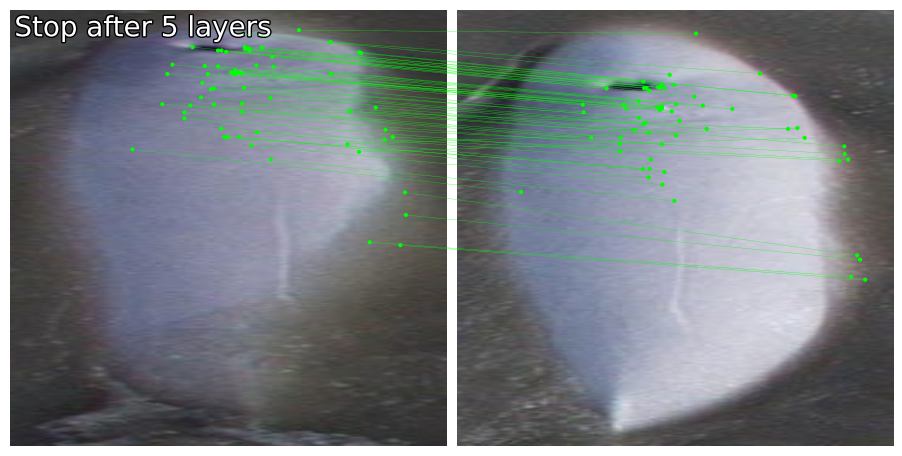

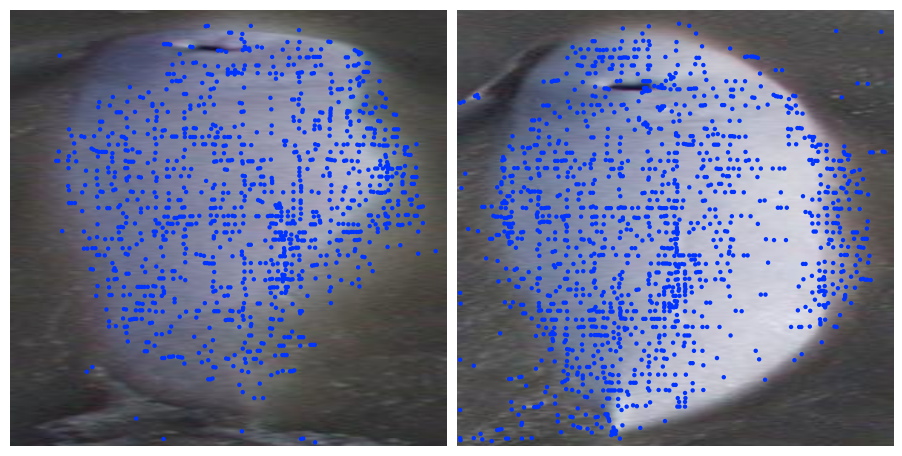

In [5]:
# Iterate through instance-match pairs
idx_to_match_idxs = {idx:topk_idx[idx].tolist() for idx in range(len(images))}
for idx, match_idxs in tqdm(idx_to_match_idxs.items()):
    image0 = images[idx]
    for match in match_idxs:
        image1 = images[match]
        feats0, feats1, matches01 = _lightglue(image0, image1)
        _lightglue_vis(image0, image1, feats0, feats1, matches01)
        break
    break

### GradCam

In [ ]:
# INSERT GRADCAM INSTALLATION HERE #
#pip install ...

In [2]:
import os
import pandas as pd
import torch
import typing as tp

from pathlib import Path

In [3]:
root = Path("/srv/transparency/wildbook_prototype/data/beluga_example_miewid")
os.listdir(root)

['images',
 'benchmark_model',
 'benchmark_splits',
 'model',
 'splits',
 'annotations.csv']

In [29]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wbia_miew_id.evaluate import Evaluator

from wbia_miew_id.visualization import render_single_query_result
from wbia_miew_id.visualization import draw_batch
from wbia_miew_id.visualization import SimilarityToConceptTarget
from wbia_miew_id.visualization import generate_embeddings

from wbia_miew_id.datasets.default_dataset import MiewIdDataset

from wbia_miew_id.engine import calculate_matches
from wbia_miew_id.engine import eval_fn, group_eval_run

from wbia_miew_id.datasets import get_test_transforms

from pytorch_grad_cam import GradCAMPlusPlus

# globals to be used for consistency
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_params = {
    'model_name': 'efficientnetv2_rw_m',
    'use_fc': False,
    'fc_dim': 2048,
    'dropout': 0,
    'loss_module': 'arcface_subcenter_dynamic',
    's': 51.960399844266306,
    'margin': 0.32841442327915477,
    'pretrained': True,
    'n_classes': 11968,
    'k': 3
}

evaluator = Evaluator(
    device=device,
    seed=0,
    anno_path=str(Path(root,'benchmark_splits/test.csv')),
    name_keys=['name'],
    viewpoint_list=None,
    use_full_image_path=True,
    images_dir=None,
    image_size=(440, 440),
    crop_bbox=True,
    valid_batch_size=12,
    num_workers=8,
    eval_groups=[['species', 'viewpoint']],
    fliplr=False,
    fliplr_view=[],
    n_filter_min=2,
    n_subsample_max=10,
    model_params=model_params,
    checkpoint_path = '/srv/transparency/wildbook_prototype/data/beluga-model-data/beluga-single-species.bin',
    model=None,
    visualize=True,
    visualization_output_dir='/home/jwidjaja/temp_dir'
)

# helpers

# Creates a new Pytorch dataloader from two indices
def create_dataloader(d, idx1, idx2):
    # Extract the data from original dataset
    data1 = d[idx1]
    data1['name'] = data1['label']
    data2 = d[idx2]
    data1['name'] = data2['label']

    # Create a new MiewIdDataset object from extracted data
    new_dataset = MiewIdDataset(
        pd.DataFrame.from_dict([data1,data2]),
        transforms=get_test_transforms((evaluator.image_size[0], evaluator.image_size[1])),
        fliplr=evaluator.fliplr,
        fliplr_view=evaluator.fliplr_view,
        crop_bbox=evaluator.crop_bbox,
    )

    # Create a new DataLoader from the MiewIdDataset
    loader = torch.utils.data.DataLoader(
        new_dataset,
        batch_size=1,
        num_workers=0,
        shuffle=False,
        pin_memory=True,
        drop_last=False
    )
    return loader

def create_dataframe(df, idx1, idx2):
    df_dict = df.to_dict('records')
    df_result = pd.DataFrame([df_dict[idx1], df_dict[idx2]])
    return df_result

def create_config():
    return {
        "device":{
            "engine": "cuda"
        }
    }

# main functions
def _gradcam(image1, image2, model):
    # Create a new dataloader from the two image indices
    loader = create_dataloader(test_dataset, image1, image2)
    model.eval()

    # Generate the embeddings and extract relevant fields
    embeddings, labels, images, paths, bboxes, thetas = generate_embeddings("cuda", evaluator.model, loader)

    # Extract features
    image1_features = embeddings.iloc[0].values
    image1_features = torch.Tensor(image1_features).to("cuda")

    image2_features = embeddings.iloc[1].values
    image2_features = torch.Tensor(image2_features).to("cuda")

    similarity1 = SimilarityToConceptTarget(image1_features)
    similarity2 = SimilarityToConceptTarget(image2_features)

    print(similarity1.features)
    
    image1_ = images[0].unsqueeze(0)
    image2_ = images[1].unsqueeze(0)

    # Create GradCAM++ Object and generate results
    target_layers = model.backbone.conv_head
    generate_cam = GradCAMPlusPlus(model=model,target_layers=[target_layers],use_cuda=True)

    stack_tensor = torch.cat([image1_, image2_])
    stack_target = [similarity1, similarity2]
    results_cam = generate_cam(input_tensor=stack_tensor, targets=stack_target, aug_smooth=False, eigen_smooth=False)
    return results_cam


Building Model Backbone for efficientnetv2_rw_m model
['backbone.conv_stem.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.bn1.num_batches_tracked', 'backbone.blocks.0.0.conv_exp.weight', 'backbone.blocks.0.0.bn1.weight', 'backbone.blocks.0.0.bn1.bias', 'backbone.blocks.0.0.bn1.running_mean', 'backbone.blocks.0.0.bn1.running_var', 'backbone.blocks.0.0.bn1.num_batches_tracked', 'backbone.blocks.0.0.conv_pwl.weight', 'backbone.blocks.0.0.bn2.weight', 'backbone.blocks.0.0.bn2.bias', 'backbone.blocks.0.0.bn2.running_mean', 'backbone.blocks.0.0.bn2.running_var', 'backbone.blocks.0.0.bn2.num_batches_tracked', 'backbone.blocks.0.1.conv_exp.weight', 'backbone.blocks.0.1.bn1.weight', 'backbone.blocks.0.1.bn1.bias', 'backbone.blocks.0.1.bn1.running_mean', 'backbone.blocks.0.1.bn1.running_var', 'backbone.blocks.0.1.bn1.num_batches_tracked', 'backbone.blocks.0.1.conv_pwl.weight', 'backbone.blocks.0.1.bn2.weight', 'backbone.blo

In [5]:
# Create some more relevant objects to be used for the visualizer
_, df_test = evaluator.preprocess_test_data(
    evaluator.anno_path, evaluator.name_keys, evaluator.viewpoint_list,
    evaluator.use_full_image_path, evaluator.images_dir, evaluator.image_size, evaluator.crop_bbox, 
    evaluator.valid_batch_size, evaluator.num_workers, evaluator.fliplr,
    evaluator.fliplr_view, evaluator.n_filter_min, evaluator.n_subsample_max
)

test_dataset = MiewIdDataset(
    csv=df_test,
    transforms=get_test_transforms((evaluator.image_size[0], evaluator.image_size[1])),
    fliplr=evaluator.fliplr,
    fliplr_view=evaluator.fliplr_view,
    crop_bbox=evaluator.crop_bbox,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=evaluator.valid_batch_size,
    num_workers=evaluator.num_workers,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

images_path = Path(root, "images")
    
def rename_filepaths(x):
    return str(Path(images_path, x.file_name))

df_test['file_path'] = df_test.apply(rename_filepaths, axis=1)

      849 annotations remain after filtering by min 2 per name_species
      849 annotations remain after subsampling by max 10 per name_species


In [159]:
# Create a gradcam visualizer using ID instead of image index
# because of how the repo code is structured
def _vis_gradcam(id1, id2, orientation):
    # loader = create_dataloader(test_dataset, idx1, idx2)

    # df_new = create_dataframe(df_test, idx1, idx2)
    
    test_score, cmc, test_outputs = eval_fn(test_loader, evaluator.model, evaluator.device, use_wandb=False, return_outputs=True)
    
    # if evaluator.eval_groups:
    #     custom_eval_groups(evaluator.eval_groups, evaluator.name_keys, evaluator.viewpoint_list, evaluator.use_full_image_path, evaluator.images_dir, evaluator.model)
    
    if evaluator.visualize:
        evaluator.visualize_results(test_outputs, df_test, test_loader.dataset, evaluator.model, evaluator.device, k=1, valid_batch_size=evaluator.valid_batch_size, output_dir=evaluator.visualization_output_dir)

    img = mpimg.imread(Path(evaluator.visualization_output_dir, f"vis_{id1}_{orientation}_{id2}_top1.jpg"))
    imgplot = plt.imshow(img)
    plt.show()

In [30]:
# BENCHMARK GRADCAM HERE #
%timeit -n 2 _gradcam(random.choice(range(len(images))), random.choice(range(len(images))), evaluator.model)

  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.79it/s]

{'image': tensor([[[[-1.3302, -1.3302, -1.3302,  ..., -1.1589, -1.1418, -1.1418],
          [-1.2617, -1.2617, -1.2617,  ..., -1.1932, -1.1932, -1.1932],
          [-1.2103, -1.2103, -1.2103,  ..., -1.2445, -1.2445, -1.2445],
          ...,
          [-1.0904, -1.0904, -1.0904,  ..., -1.1075, -1.1589, -1.1589],
          [-1.0562, -1.0562, -1.0562,  ..., -1.1932, -1.2617, -1.2788],
          [-1.0219, -1.0219, -1.0048,  ..., -1.2959, -1.3302, -1.3302]],

         [[-1.3354, -1.3354, -1.3354,  ..., -1.0553, -1.0378, -1.0378],
          [-1.2654, -1.2654, -1.2654,  ..., -1.0903, -1.0903, -1.0903],
          [-1.2129, -1.2129, -1.2129,  ..., -1.1429, -1.1429, -1.1429],
          ...,
          [-1.0028, -1.0028, -1.0028,  ..., -0.9678, -1.0203, -1.0203],
          [-0.9678, -0.9678, -0.9678,  ..., -1.0553, -1.1253, -1.1429],
          [-0.9328, -0.9328, -0.9153,  ..., -1.1604, -1.1954, -1.1954]],

         [[-1.0376, -1.0376, -1.0376,  ..., -0.8633, -0.8458, -0.8458],
          [-0.9678, 

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([ 1.2983,  0.3353, -0.2551,  ...,  0.9366, -0.5240,  0.7406],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.22it/s]

{'image': tensor([[[[-0.5767, -0.5767, -0.6109,  ..., -0.6623, -0.6623, -0.6623],
          [-0.5424, -0.5424, -0.5596,  ..., -0.7650, -0.7822, -0.7822],
          [-0.6452, -0.6452, -0.6452,  ..., -0.9534, -0.9705, -0.9705],
          ...,
          [-0.6794, -0.6794, -0.6794,  ..., -0.8507, -0.8335, -0.8335],
          [-0.7479, -0.7479, -0.7479,  ..., -0.8335, -0.8335, -0.8335],
          [-0.7993, -0.7993, -0.7993,  ..., -0.8164, -0.8164, -0.8164]],

         [[-0.5651, -0.5651, -0.6001,  ..., -0.5476, -0.5476, -0.5476],
          [-0.5301, -0.5301, -0.5476,  ..., -0.6527, -0.6702, -0.6702],
          [-0.6352, -0.6352, -0.6352,  ..., -0.8452, -0.8627, -0.8627],
          ...,
          [-0.5651, -0.5651, -0.5651,  ..., -0.6702, -0.6527, -0.6527],
          [-0.6001, -0.6001, -0.6001,  ..., -0.6176, -0.6176, -0.6176],
          [-0.6001, -0.6001, -0.6001,  ..., -0.6001, -0.6001, -0.6001]],

         [[-0.3404, -0.3404, -0.3753,  ..., -0.3230, -0.3230, -0.3230],
          [-0.3055, 

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([ 0.3400,  1.4001,  1.5387,  ..., -0.1651,  0.0016, -0.8740],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),


{'image': tensor([[[[-1.2103, -1.2103, -1.1932,  ...,  1.9920,  1.9920,  1.9920],
          [-1.1589, -1.1589, -1.1418,  ...,  1.9920,  1.9920,  1.9920],
          [-1.0904, -1.0904, -1.0733,  ...,  1.9920,  1.9920,  1.9920],
          ...,
          [-1.3644, -1.3644, -1.3130,  ..., -1.1589, -1.1418, -1.1418],
          [-1.2617, -1.2617, -1.2274,  ..., -1.1589, -1.1589, -1.1589],
          [-1.0562, -1.0562, -1.0390,  ..., -1.2445, -1.2274, -1.2274]],

         [[-1.1078, -1.1078, -1.0903,  ...,  2.1660,  2.1660,  2.1660],
          [-1.0553, -1.0553, -1.0378,  ...,  2.1660,  2.1660,  2.1660],
          [-0.9853, -0.9853, -0.9678,  ...,  2.1660,  2.1660,  2.1660],
          ...,
          [-1.3004, -1.3004, -1.2479,  ..., -1.0553, -1.0378, -1.0378],
          [-1.1954, -1.1954, -1.1604,  ..., -1.0553, -1.0378, -1.0378],
          [-0.9853, -0.9853, -0.9678,  ..., -1.1253, -1.1078, -1.1078]],

         [[-0.8807, -0.8807, -0.8633,  ...,  2.3786,  2.3786,  2.3786],
          [-0.8284, 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.74it/s]

tensor([[ 0.3033, -0.9185,  0.8388,  ...,  0.4209,  0.3277,  0.0623]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
generating embeddings


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([-0.6204, -0.2984, -0.2108,  ..., -0.9797, -0.6056,  1.8312],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),


{'image': tensor([[[[-1.1418, -1.1418, -1.1589,  ..., -0.9363, -0.9705, -0.9705],
          [-1.0904, -1.0904, -1.1075,  ..., -0.8849, -0.9020, -0.9020],
          [-1.0219, -1.0219, -1.0562,  ..., -0.7308, -0.6965, -0.6794],
          ...,
          [-1.0562, -1.0562, -1.0562,  ..., -1.1418, -1.1418, -1.1418],
          [-1.0562, -1.0562, -1.0562,  ..., -1.1418, -1.1418, -1.1418],
          [-1.0562, -1.0562, -1.0562,  ..., -1.1247, -1.1247, -1.1247]],

         [[-1.0553, -1.0553, -1.0728,  ..., -0.8102, -0.8452, -0.8452],
          [-1.0028, -1.0028, -1.0203,  ..., -0.7577, -0.7752, -0.7752],
          [-0.9328, -0.9328, -0.9678,  ..., -0.6001, -0.5651, -0.5476],
          ...,
          [-0.9328, -0.9328, -0.9328,  ..., -1.0728, -1.0728, -1.0728],
          [-0.9328, -0.9328, -0.9328,  ..., -1.0728, -1.0728, -1.0728],
          [-0.9328, -0.9328, -0.9328,  ..., -1.0553, -1.0553, -1.0553]],

         [[-0.8633, -0.8633, -0.8807,  ..., -0.6890, -0.7238, -0.7238],
          [-0.8110, 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.37it/s]

generating embeddings


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([ 0.4952, -0.2663,  0.6396,  ...,  0.3460, -0.2758, -0.8826],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),


{'image': tensor([[[[-1.0048, -1.0048, -1.0048,  ..., -0.8678, -0.8678, -0.8678],
          [-1.0048, -1.0048, -1.0048,  ..., -0.8849, -0.8849, -0.8849],
          [-1.0048, -1.0048, -1.0048,  ..., -0.9363, -0.9363, -0.9363],
          ...,
          [-1.0048, -1.0048, -1.0048,  ..., -1.0390, -1.0390, -1.0390],
          [-1.0048, -1.0048, -1.0048,  ..., -1.0390, -1.0390, -1.0390],
          [-0.9705, -0.9705, -0.9705,  ..., -1.0219, -1.0219, -1.0219]],

         [[-0.9153, -0.9153, -0.9153,  ..., -0.7752, -0.7752, -0.7752],
          [-0.9153, -0.9153, -0.9153,  ..., -0.7927, -0.7927, -0.7927],
          [-0.9153, -0.9153, -0.9153,  ..., -0.8452, -0.8452, -0.8452],
          ...,
          [-0.8978, -0.8978, -0.8978,  ..., -0.9678, -0.9678, -0.9678],
          [-0.8978, -0.8978, -0.8978,  ..., -0.9678, -0.9678, -0.9678],
          [-0.8627, -0.8627, -0.8627,  ..., -0.9503, -0.9503, -0.9503]],

         [[-0.7238, -0.7238, -0.7238,  ..., -0.5844, -0.5844, -0.5844],
          [-0.7238, 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.48it/s]

tensor([[ 0.5766,  1.0857,  0.7154,  ...,  0.7947, -0.1893, -0.3657]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
{'image': tensor([[[[-0.7479, -0.7479, -0.7479,  ..., -0.7137, -0.7137, -0.7137],
          [-0.7479, -0.7479, -0.7479,  ..., -0.7308, -0.7137, -0.7137],
          [-0.7479, -0.7479, -0.7308,  ..., -0.7137, -0.7137, -0.7137],
          ...,
          [-0.7137, -0.6965, -0.6281,  ..., -0.0458, -0.0972, -0.1143],
          [-0.6623, -0.6452, -0.6109,  ...,  0.0741,  0.0056, -0.0116],
          [-0.5596, -0.5596, -0.5596,  ..., -0.0287, -0.0801, -0.0972]],

         [[-0.6352, -0.6352, -0.6352,  ..., -0.6001, -0.6001, -0.6001],
          [-0.6352, -0.6352, -0.6352,  ..., -0.6176, -0.6001, -0.6001],
          [-0.6352, -0.6352, -0.6176,  ..., -0.6001, -0.6001, -0.6001],
          ...,
          [-0.6877, -0.6702, -0.6001,  ...,  0.1527,  0.1176,  0.1001],
          [-0.6352, -0.6176, -0.5826,  ...,  0.3277,  0.2927,  0.2752],
          [-0.5301, -0.5301, -0.530

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([ 0.5766,  1.0857,  0.7154,  ...,  0.7947, -0.1893, -0.3657],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.60it/s]

{'image': tensor([[[[-0.8164, -0.8164, -0.7993,  ..., -1.1418, -1.1589, -1.1589],
          [-0.7993, -0.7993, -0.7822,  ..., -1.2274, -1.2617, -1.2617],
          [-0.7822, -0.7822, -0.7650,  ..., -1.2617, -1.2959, -1.2959],
          ...,
          [-1.1247, -1.1247, -1.0733,  ..., -1.1760, -1.1589, -1.1589],
          [-1.2274, -1.2274, -1.1760,  ..., -1.2103, -1.1932, -1.1932],
          [-1.3130, -1.3130, -1.2617,  ..., -1.1589, -1.1418, -1.1418]],

         [[-0.6352, -0.6352, -0.6176,  ..., -1.0378, -1.0553, -1.0553],
          [-0.6176, -0.6176, -0.6001,  ..., -1.1253, -1.1604, -1.1604],
          [-0.6001, -0.6001, -0.5826,  ..., -1.1604, -1.1954, -1.1954],
          ...,
          [-1.0203, -1.0203, -0.9678,  ..., -1.1779, -1.1604, -1.1604],
          [-1.1253, -1.1253, -1.0728,  ..., -1.1954, -1.1954, -1.1954],
          [-1.2129, -1.2129, -1.1604,  ..., -1.1429, -1.1429, -1.1429]],

         [[-0.4275, -0.4275, -0.4101,  ..., -0.8110, -0.8284, -0.8284],
          [-0.4101, 

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([ 0.0860,  0.1771,  1.0976,  ...,  0.3276, -0.0081,  0.0215],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),


{'image': tensor([[[[-1.4500, -1.4500, -1.4500,  ..., -1.5014, -1.5014, -1.5014],
          [-1.4158, -1.4158, -1.4158,  ..., -1.5014, -1.5014, -1.5014],
          [-1.4329, -1.4329, -1.4329,  ..., -1.5014, -1.5014, -1.5014],
          ...,
          [-1.4672, -1.4672, -1.4672,  ..., -1.4500, -1.4500, -1.4500],
          [-1.5357, -1.5357, -1.5185,  ..., -1.4329, -1.4329, -1.4329],
          [-1.4843, -1.4843, -1.4500,  ..., -1.4158, -1.4158, -1.4158]],

         [[-1.2654, -1.2654, -1.2654,  ..., -1.4230, -1.4230, -1.4230],
          [-1.2304, -1.2304, -1.2304,  ..., -1.4230, -1.4230, -1.4230],
          [-1.2479, -1.2479, -1.2479,  ..., -1.4230, -1.4230, -1.4230],
          ...,
          [-1.4580, -1.4580, -1.4580,  ..., -1.3529, -1.3529, -1.3529],
          [-1.5280, -1.5280, -1.5105,  ..., -1.3354, -1.3354, -1.3354],
          [-1.4755, -1.4755, -1.4405,  ..., -1.3179, -1.3179, -1.3179]],

         [[-1.1073, -1.1073, -1.1073,  ..., -1.2293, -1.2293, -1.2293],
          [-1.0724, 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.07it/s]

tensor([[ 0.1225,  1.3615, -0.0070,  ...,  0.1091, -0.6066, -0.3642]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
generating embeddings


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([-0.7877, -0.6962,  0.1155,  ..., -0.2189, -1.1429, -0.7332],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),


{'image': tensor([[[[-0.6794, -0.6794, -0.6965,  ..., -0.2171, -0.1999, -0.1999],
          [-0.6965, -0.6965, -0.7137,  ..., -0.2513, -0.2342, -0.2342],
          [-0.7479, -0.7479, -0.7650,  ..., -0.3369, -0.3198, -0.3198],
          ...,
          [-0.6623, -0.6623, -0.4911,  ..., -1.4158, -1.4158, -1.4158],
          [-0.6452, -0.6452, -0.7479,  ..., -1.4672, -1.4843, -1.4843],
          [-0.8507, -0.8507, -0.7308,  ..., -1.4843, -1.4843, -1.4843]],

         [[-0.6352, -0.6352, -0.6527,  ..., -0.1625, -0.1450, -0.1450],
          [-0.6527, -0.6527, -0.6702,  ..., -0.1975, -0.1800, -0.1800],
          [-0.7052, -0.7052, -0.7227,  ..., -0.2500, -0.2325, -0.2325],
          ...,
          [-0.5651, -0.5651, -0.3901,  ..., -1.3004, -1.2829, -1.2829],
          [-0.5476, -0.5476, -0.6527,  ..., -1.3179, -1.3179, -1.3179],
          [-0.7577, -0.7577, -0.6352,  ..., -1.3179, -1.3179, -1.3179]],

         [[-0.4624, -0.4624, -0.4798,  ..., -0.1312, -0.1138, -0.1138],
          [-0.4798, 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.99it/s]

tensor([[-0.2833, -1.0671,  0.5252,  ...,  0.5443,  0.9575,  1.6681]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
generating embeddings


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([-0.3078, -0.8419,  0.5510,  ..., -0.5463,  1.3113, -1.2526],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),


{'image': tensor([[[[-0.8678, -0.8678, -0.8507,  ..., -0.7137, -0.6965, -0.6965],
          [-0.7479, -0.7479, -0.7308,  ..., -0.6794, -0.6623, -0.6623],
          [-0.5253, -0.5253, -0.5082,  ..., -0.6965, -0.6794, -0.6794],
          ...,
          [-0.7650, -0.7650, -0.7822,  ..., -0.8335, -0.8335, -0.8335],
          [-0.8335, -0.8335, -0.8335,  ..., -0.8335, -0.8335, -0.8335],
          [-0.9020, -0.9020, -0.8849,  ..., -0.8164, -0.8164, -0.8164]],

         [[-0.6877, -0.6877, -0.6702,  ..., -0.5126, -0.4951, -0.4951],
          [-0.5651, -0.5651, -0.5476,  ..., -0.4776, -0.4601, -0.4601],
          [-0.3375, -0.3375, -0.3200,  ..., -0.5476, -0.5301, -0.5301],
          ...,
          [-0.6527, -0.6527, -0.6702,  ..., -0.7227, -0.7227, -0.7227],
          [-0.7227, -0.7227, -0.7227,  ..., -0.7227, -0.7227, -0.7227],
          [-0.7927, -0.7927, -0.7752,  ..., -0.7052, -0.7052, -0.7052]],

         [[-0.4798, -0.4798, -0.4624,  ..., -0.3578, -0.3404, -0.3404],
          [-0.3578, 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.12it/s]

tensor([[ 0.2059, -0.3334,  0.8227,  ...,  0.2614, -0.1764,  0.4379]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
generating embeddings


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([ 3.1063, -1.1287,  0.9159,  ...,  1.3219, -0.0920,  1.4397],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),


{'image': tensor([[[[-1.0390, -1.0390, -1.0562,  ..., -1.0390, -1.0390, -1.0390],
          [-0.8849, -0.8849, -0.9020,  ..., -1.0219, -1.0219, -1.0219],
          [-0.9192, -0.9192, -0.9363,  ..., -1.0219, -1.0219, -1.0219],
          ...,
          [-0.7650, -0.7650, -0.7822,  ..., -1.1589, -1.1589, -1.1589],
          [-0.8335, -0.8335, -0.8335,  ..., -1.1589, -1.1760, -1.1760],
          [-0.9534, -0.9534, -0.9534,  ..., -1.1589, -1.1760, -1.1760]],

         [[-0.9678, -0.9678, -0.9853,  ..., -0.9503, -0.9503, -0.9503],
          [-0.8102, -0.8102, -0.8277,  ..., -0.9328, -0.9328, -0.9328],
          [-0.8452, -0.8452, -0.8627,  ..., -0.9328, -0.9328, -0.9328],
          ...,
          [-0.7227, -0.7227, -0.7402,  ..., -1.0903, -1.0903, -1.0903],
          [-0.7927, -0.7927, -0.7927,  ..., -1.0903, -1.1078, -1.1078],
          [-0.9153, -0.9153, -0.9153,  ..., -1.0903, -1.1078, -1.1078]],

         [[-0.7238, -0.7238, -0.7413,  ..., -0.7587, -0.7587, -0.7587],
          [-0.5670, 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.17it/s]

tensor([[-0.2437,  0.3158,  0.0987,  ..., -0.4408,  0.1982,  0.7996]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
generating embeddings


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([-0.0389,  1.3886,  0.7327,  ..., -0.0436,  0.3431, -0.3935],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]

{'image': tensor([[[[-0.5253, -0.5253, -0.5767,  ..., -1.1247, -1.1075, -1.1075],
          [ 0.2967,  0.2967,  0.2282,  ..., -1.0219, -1.0048, -1.0048],
          [ 0.8104,  0.8104,  0.7933,  ..., -1.0219, -1.0219, -1.0219],
          ...,
          [-1.1075, -1.1075, -1.1075,  ..., -1.0390, -1.0390, -1.0390],
          [-1.0904, -1.0904, -1.0904,  ..., -1.0562, -1.0562, -1.0562],
          [-1.0219, -1.0219, -1.0219,  ..., -1.0390, -1.0390, -1.0390]],

         [[-0.4601, -0.4601, -0.5126,  ..., -0.9153, -0.8978, -0.8978],
          [ 0.3803,  0.3803,  0.3102,  ..., -0.8452, -0.8277, -0.8277],
          [ 0.9055,  0.9055,  0.8880,  ..., -0.8452, -0.8452, -0.8452],
          ...,
          [-0.9328, -0.9328, -0.9328,  ..., -0.9328, -0.9328, -0.9328],
          [-0.9153, -0.9153, -0.9153,  ..., -0.9503, -0.9503, -0.9503],
          [-0.8452, -0.8452, -0.8452,  ..., -0.9328, -0.9328, -0.9328]],

         [[-0.0441, -0.0441, -0.0964,  ..., -0.7238, -0.7064, -0.7064],
          [ 0.7925, 

/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.16it/s]

tensor([[ 0.7914, -0.7176,  1.6689,  ...,  0.5300, -0.5548,  0.4853]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
{'image': tensor([[[[-0.9020, -0.9020, -0.9020,  ..., -0.7993, -0.8164, -0.8164],
          [-0.8507, -0.8507, -0.8678,  ..., -0.7822, -0.7993, -0.7993],
          [-0.7650, -0.7650, -0.7993,  ..., -0.7137, -0.7137, -0.7137],
          ...,
          [-0.0629, -0.0629, -0.0629,  ..., -0.8335, -0.8164, -0.8164],
          [-0.2513, -0.2513, -0.2513,  ..., -0.9363, -0.9363, -0.9363],
          [-0.3369, -0.3369, -0.3369,  ..., -0.8678, -0.8678, -0.8678]],

         [[-0.8102, -0.8102, -0.8102,  ..., -0.6527, -0.6527, -0.6527],
          [-0.7577, -0.7577, -0.7752,  ..., -0.6352, -0.6352, -0.6352],
          [-0.6527, -0.6527, -0.6877,  ..., -0.5826, -0.5826, -0.5826],
          ...,
          [-0.0224, -0.0224, -0.0224,  ..., -0.6877, -0.6877, -0.6877],
          [-0.1800, -0.1800, -0.1800,  ..., -0.7752, -0.7752, -0.7752],
          [-0.2675, -0.2675, -0.267

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([ 0.7914, -0.7176,  1.6689,  ...,  0.5300, -0.5548,  0.4853],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.59it/s]

{'image': tensor([[[[-0.8507, -0.8507, -0.8164,  ..., -0.7308, -0.7308, -0.7308],
          [-0.7993, -0.7993, -0.7822,  ..., -0.8335, -0.8335, -0.8335],
          [-0.6623, -0.6623, -0.6623,  ..., -0.8164, -0.8164, -0.8164],
          ...,
          [-0.8849, -0.8849, -0.8849,  ..., -0.7822, -0.7822, -0.7822],
          [-0.7822, -0.7822, -0.7822,  ..., -0.7479, -0.7479, -0.7479],
          [-0.7479, -0.7479, -0.7479,  ..., -0.9020, -0.9020, -0.9020]],

         [[-0.6702, -0.6702, -0.6352,  ..., -0.7752, -0.7752, -0.7752],
          [-0.6176, -0.6176, -0.6001,  ..., -0.8803, -0.8803, -0.8803],
          [-0.4776, -0.4776, -0.4776,  ..., -0.8627, -0.8627, -0.8627],
          ...,
          [-0.8452, -0.8452, -0.8452,  ..., -0.7402, -0.7402, -0.7402],
          [-0.7402, -0.7402, -0.7402,  ..., -0.7052, -0.7052, -0.7052],
          [-0.7052, -0.7052, -0.7052,  ..., -0.8627, -0.8627, -0.8627]],

         [[-0.2358, -0.2358, -0.2010,  ..., -0.5321, -0.5321, -0.5321],
          [-0.1835, 

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([-0.3388, -0.1652,  0.8143,  ..., -0.8402, -0.4582,  0.4731],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),


{'image': tensor([[[[-1.2445, -1.2445, -1.2445,  ..., -1.1589, -1.1589, -1.1589],
          [-1.2788, -1.2788, -1.2788,  ..., -1.2103, -1.1932, -1.1932],
          [-1.3130, -1.3130, -1.3130,  ..., -1.2274, -1.2103, -1.2103],
          ...,
          [-1.3302, -1.3302, -1.3302,  ..., -1.2445, -1.2274, -1.2274],
          [-1.3473, -1.3473, -1.3473,  ..., -1.2445, -1.2445, -1.2445],
          [-1.3987, -1.3987, -1.3987,  ..., -1.2959, -1.2959, -1.2959]],

         [[-1.1429, -1.1429, -1.1429,  ..., -1.1604, -1.1604, -1.1604],
          [-1.1779, -1.1779, -1.1779,  ..., -1.1954, -1.1954, -1.1954],
          [-1.2129, -1.2129, -1.2129,  ..., -1.1954, -1.1779, -1.1779],
          ...,
          [-1.0728, -1.0728, -1.0728,  ..., -1.1604, -1.1429, -1.1429],
          [-1.1429, -1.1429, -1.1429,  ..., -1.1604, -1.1604, -1.1604],
          [-1.1954, -1.1954, -1.1954,  ..., -1.2129, -1.2129, -1.2129]],

         [[-0.9156, -0.9156, -0.9156,  ..., -0.8981, -0.8981, -0.8981],
          [-0.9504, 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 20.90it/s]

tensor([[0.5474, 1.0131, 2.1254,  ..., 1.5974, 1.2934, 0.3445]],
       device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
generating embeddings


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([-0.4049,  0.0327,  0.6182,  ...,  0.9017, -0.2588,  2.4191],
       device='cuda:0')


  0%|                                                                                                                                                                           | 0/2 [00:00<?, ?it/s]/home/jwidjaja/wbia-plugin-miew-id/wbia_miew_id/datasets/default_dataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"image": image, "label":torch.tensor(row['name']),


{'image': tensor([[[[-0.7308, -0.7137, -0.5596,  ..., -0.8678, -0.8335, -0.8335],
          [-0.6452, -0.6452, -0.5767,  ..., -0.7308, -0.7137, -0.7137],
          [-0.6281, -0.6281, -0.6623,  ..., -0.8164, -0.8335, -0.8335],
          ...,
          [-0.8335, -0.8335, -0.8335,  ..., -1.0733, -1.0904, -1.0904],
          [-0.8164, -0.8164, -0.8164,  ..., -1.0904, -1.0904, -1.0904],
          [-0.7993, -0.7993, -0.7993,  ..., -1.1075, -1.0904, -1.0904]],

         [[-0.6176, -0.6001, -0.4426,  ..., -0.7752, -0.7577, -0.7577],
          [-0.5301, -0.5301, -0.4601,  ..., -0.6527, -0.6352, -0.6352],
          [-0.5126, -0.5126, -0.5476,  ..., -0.7227, -0.7577, -0.7577],
          ...,
          [-0.7577, -0.7577, -0.7577,  ..., -0.9678, -0.9853, -0.9853],
          [-0.7402, -0.7402, -0.7402,  ..., -0.9853, -0.9853, -0.9853],
          [-0.7227, -0.7227, -0.7227,  ..., -1.0028, -0.9853, -0.9853]],

         [[-0.3578, -0.3404, -0.1835,  ..., -0.4624, -0.4450, -0.4450],
          [-0.2707, 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 21.24it/s]

generating embeddings


  0%|          | 0/2 [00:00<?, ?it/s]

tensor([ 0.1350, -0.1063,  0.5817,  ...,  1.1854, -0.6078,  0.9630],
       device='cuda:0')
313 ms ± 58.6 ms per loop (mean ± std. dev. of 7 runs, 2 loops each)


  0%|                                                                                                                                                                         | 0/849 [00:00<?, ?it/s]

4


  0%|          | 0/71 [00:00<?, ?it/s]

Computing CMC and mAP ...
Computed rank metrics on 849 examples
** Avg Results **
mAP: 53.8%
CMC curve
Rank-1  : 62.8%
Rank-5  : 73.5%
Rank-10 : 78.9%
Rank-20 : 83.5%
Generating visualizations...


  0%|          | 0/849 [00:00<?, ?it/s]

** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_0_up_0_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_0_up_1_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_0_up_2_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_0_up_3_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_0_up_4_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_0_up_5_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_0_up_6_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_0_up_7_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_0_up_8_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_0_up_9_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_1_up_10_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_1_up_11_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_1_up_12_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_1_up_13_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_1_up_14_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_1_up_15_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_1_up_16_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_2_up_17_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_2_up_18_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_3_up_19_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_3_up_20_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_3_up_21_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_4_up_22_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_4_up_23_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_4_up_24_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_5_up_25_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_5_up_26_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_6_up_27_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_6_up_28_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_7_up_29_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_7_up_30_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_7_up_31_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_8_up_32_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_8_up_33_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_8_up_34_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_8_up_35_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_8_up_36_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_8_up_37_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_8_up_38_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_9_up_39_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_9_up_40_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_9_up_41_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_10_up_42_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_10_up_43_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_10_up_44_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_10_up_45_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_10_up_46_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_10_up_47_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_12_up_48_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_12_up_49_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_12_up_50_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_13_up_51_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_13_up_52_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_14_up_53_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_14_up_54_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_14_up_55_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_15_up_56_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_15_up_57_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_15_up_58_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_16_up_59_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_16_up_60_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_16_up_61_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_16_up_62_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_16_up_63_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_16_up_64_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_16_up_65_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_16_up_66_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_16_up_67_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_16_up_68_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_11_up_69_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_11_up_70_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_11_up_71_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_11_up_72_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_17_up_73_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_17_up_74_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_17_up_75_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_17_up_76_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_17_up_77_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_17_up_78_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_17_up_79_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_17_up_80_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_17_up_81_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_17_up_82_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_18_up_83_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_18_up_84_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_20_up_85_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_20_up_86_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_20_up_87_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_20_up_88_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_20_up_89_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_20_up_90_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_20_up_91_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_20_up_92_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_21_up_93_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_21_up_94_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_21_up_95_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_21_up_96_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_21_up_97_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_21_up_98_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_21_up_99_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_21_up_100_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_21_up_101_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_21_up_102_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_22_up_103_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_22_up_104_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_22_up_105_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_22_up_106_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_23_up_107_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_23_up_108_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_23_up_109_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_23_up_110_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_24_up_111_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_24_up_112_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_19_up_113_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_19_up_114_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_19_up_115_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_19_up_116_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_25_up_117_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_25_up_118_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_25_up_119_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_25_up_120_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_26_up_121_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_26_up_122_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_26_up_123_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_26_up_124_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_26_up_125_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_26_up_126_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_26_up_127_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_26_up_128_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_26_up_129_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_26_up_130_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_27_up_131_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_27_up_132_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_27_up_133_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_28_up_134_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_28_up_135_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_28_up_136_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_28_up_137_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_28_up_138_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_28_up_139_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_30_up_140_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_30_up_141_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_31_up_142_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_31_up_143_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_31_up_144_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_31_up_145_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_31_up_146_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_31_up_147_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_31_up_148_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_31_up_149_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_31_up_150_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_31_up_151_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_32_up_152_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_32_up_153_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_32_up_154_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_32_up_155_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_29_up_156_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_29_up_157_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_29_up_158_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_29_up_159_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_29_up_160_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_29_up_161_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_29_up_162_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_29_up_163_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_29_up_164_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_33_up_165_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_33_up_166_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_33_up_167_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_34_up_168_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_34_up_169_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_35_up_170_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_35_up_171_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_35_up_172_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_35_up_173_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_37_up_174_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_37_up_175_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_37_up_176_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_37_up_177_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_38_up_178_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_38_up_179_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_39_up_180_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_39_up_181_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_39_up_182_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_39_up_183_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_40_up_184_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_40_up_185_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_41_up_186_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_41_up_187_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_42_up_188_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_42_up_189_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_42_up_190_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_43_up_191_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_43_up_192_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_43_up_193_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_43_up_194_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_45_up_195_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_45_up_196_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_46_up_197_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_46_up_198_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_46_up_199_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_46_up_200_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_44_up_201_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_44_up_202_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_44_up_203_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_44_up_204_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_44_up_205_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_44_up_206_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_47_up_207_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_47_up_208_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_47_up_209_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_47_up_210_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_47_up_211_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_48_up_212_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_48_up_213_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_48_up_214_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_49_up_215_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_49_up_216_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_50_up_217_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_50_up_218_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_50_up_219_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_52_up_220_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_52_up_221_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_52_up_222_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_52_up_223_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_52_up_224_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_51_up_225_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_51_up_226_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_51_up_227_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_51_up_228_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_51_up_229_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_36_up_230_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_36_up_231_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_53_up_232_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_53_up_233_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_53_up_234_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_53_up_235_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_53_up_236_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_53_up_237_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_54_up_238_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_54_up_239_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_54_up_240_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_54_up_241_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_55_up_242_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_55_up_243_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_55_up_244_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_55_up_245_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_56_up_246_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_56_up_247_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_57_up_248_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_57_up_249_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_57_up_250_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_57_up_251_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_58_up_252_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_58_up_253_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_58_up_254_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_59_up_255_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_59_up_256_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_59_up_257_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_60_up_258_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_60_up_259_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_61_up_260_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_61_up_261_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_61_up_262_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_61_up_263_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_61_up_264_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_62_up_265_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_62_up_266_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_62_up_267_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_63_up_268_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_63_up_269_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_65_up_270_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_65_up_271_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_66_up_272_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_66_up_273_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_64_up_274_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_64_up_275_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_64_up_276_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_68_up_277_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_68_up_278_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_69_up_279_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_69_up_280_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_70_up_281_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_70_up_282_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_70_up_283_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_70_up_284_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_70_up_285_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_71_up_286_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_71_up_287_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_71_up_288_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_71_up_289_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_71_up_290_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_71_up_291_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_67_up_292_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_67_up_293_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_67_up_294_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_67_up_295_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_67_up_296_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_67_up_297_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_67_up_298_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_73_up_299_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_73_up_300_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_72_up_301_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_72_up_302_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_74_up_303_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_74_up_304_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_74_up_305_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_74_up_306_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_75_up_307_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_75_up_308_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_76_up_309_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_76_up_310_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_77_up_311_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_77_up_312_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_77_up_313_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_77_up_314_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_77_up_315_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_77_up_316_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_78_up_317_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_78_up_318_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_78_up_319_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_78_up_320_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_78_up_321_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_79_up_322_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_79_up_323_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_79_up_324_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_79_up_325_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_80_up_326_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_80_up_327_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_81_up_328_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_81_up_329_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_82_up_330_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_82_up_331_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_82_up_332_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_82_up_333_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_82_up_334_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_82_up_335_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_83_up_336_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_83_up_337_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_84_up_338_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_84_up_339_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_85_up_340_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_85_up_341_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_86_up_342_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_86_up_343_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_87_up_344_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_87_up_345_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_88_up_346_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_88_up_347_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_88_up_348_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_88_up_349_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_88_up_350_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_89_up_351_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_89_up_352_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_90_up_353_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_90_up_354_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_90_up_355_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_90_up_356_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_90_up_357_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_90_up_358_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_90_up_359_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_90_up_360_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_91_up_361_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_91_up_362_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_91_up_363_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_91_up_364_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_92_up_365_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_92_up_366_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_92_up_367_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_92_up_368_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_93_up_369_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_93_up_370_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_94_up_371_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_94_up_372_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_96_up_373_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_96_up_374_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_95_up_375_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_95_up_376_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_97_up_377_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_97_up_378_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_98_up_379_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_98_up_380_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_98_up_381_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_100_up_382_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_100_up_383_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_102_up_384_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_102_up_385_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_103_up_386_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_103_up_387_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_104_up_388_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_104_up_389_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_104_up_390_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_104_up_391_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_101_up_392_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_101_up_393_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_101_up_394_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_101_up_395_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_101_up_396_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_101_up_397_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_101_up_398_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_101_up_399_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_105_up_400_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_105_up_401_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_105_up_402_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_105_up_403_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_106_up_404_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_106_up_405_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_107_up_406_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_107_up_407_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_107_up_408_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_107_up_409_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_108_up_410_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_108_up_411_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_108_up_412_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_108_up_413_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_108_up_414_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_108_up_415_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_109_up_416_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_109_up_417_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_109_up_418_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_110_up_419_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_110_up_420_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_110_up_421_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_110_up_422_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_112_up_423_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_112_up_424_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_112_up_425_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_112_up_426_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_112_up_427_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_113_up_428_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_113_up_429_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_113_up_430_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_111_up_431_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_111_up_432_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_111_up_433_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_111_up_434_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_111_up_435_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_111_up_436_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_111_up_437_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_115_up_438_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_115_up_439_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_114_up_440_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_114_up_441_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_114_up_442_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_114_up_443_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_116_up_444_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_116_up_445_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_117_up_446_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_117_up_447_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_118_up_448_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_118_up_449_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_118_up_450_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_118_up_451_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_118_up_452_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_99_up_453_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_99_up_454_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_120_up_455_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_120_up_456_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_121_up_457_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_121_up_458_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_122_up_459_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_122_up_460_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_123_up_461_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_123_up_462_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_123_up_463_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_123_up_464_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_123_up_465_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_123_up_466_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_123_up_467_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_124_up_468_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_124_up_469_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_124_up_470_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_124_up_471_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_124_up_472_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_124_up_473_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_125_up_474_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_125_up_475_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_125_up_476_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_125_up_477_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_125_up_478_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_126_up_479_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_126_up_480_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_126_up_481_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_127_up_482_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_127_up_483_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_129_up_484_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_129_up_485_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_129_up_486_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_129_up_487_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_129_up_488_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_130_up_489_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_130_up_490_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_131_up_491_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_131_up_492_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_128_up_493_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_128_up_494_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_128_up_495_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_128_up_496_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_128_up_497_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_132_up_498_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_132_up_499_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_132_up_500_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_132_up_501_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_132_up_502_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_132_up_503_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_134_up_504_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_134_up_505_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_134_up_506_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_135_up_507_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_135_up_508_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_136_up_509_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_136_up_510_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_137_up_511_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_137_up_512_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_137_up_513_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_137_up_514_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_137_up_515_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_137_up_516_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_137_up_517_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_133_up_518_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_133_up_519_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_138_up_520_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_138_up_521_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_140_up_522_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_140_up_523_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_140_up_524_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_141_up_525_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_141_up_526_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_141_up_527_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_141_up_528_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_141_up_529_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_141_up_530_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_142_up_531_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_142_up_532_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_142_up_533_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_143_up_534_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_143_up_535_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_143_up_536_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_144_up_537_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_144_up_538_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_144_up_539_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_144_up_540_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_144_up_541_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_144_up_542_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_139_up_543_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_139_up_544_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_145_up_545_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_145_up_546_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_145_up_547_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_145_up_548_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_119_up_549_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_119_up_550_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_119_up_551_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_146_up_552_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_146_up_553_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_146_up_554_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_147_up_555_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_147_up_556_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_147_up_557_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_147_up_558_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_147_up_559_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_147_up_560_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_147_up_561_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_148_up_562_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_148_up_563_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_148_up_564_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_148_up_565_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_149_up_566_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_149_up_567_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_149_up_568_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_150_up_569_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_150_up_570_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_150_up_571_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_150_up_572_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_151_up_573_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_151_up_574_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_152_up_575_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_152_up_576_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_152_up_577_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_152_up_578_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_152_up_579_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_153_up_580_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_153_up_581_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_154_up_582_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_154_up_583_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_154_up_584_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_155_up_585_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_155_up_586_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_155_up_587_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_155_up_588_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_156_up_589_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_156_up_590_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_156_up_591_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_156_up_592_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_156_up_593_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_156_up_594_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_157_up_595_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_157_up_596_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_158_up_597_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_158_up_598_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_159_up_599_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_159_up_600_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_161_up_601_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_161_up_602_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_161_up_603_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_161_up_604_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_162_up_605_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_162_up_606_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_162_up_607_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_163_up_608_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_163_up_609_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_163_up_610_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_163_up_611_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_163_up_612_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_160_up_613_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_160_up_614_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_165_up_615_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_165_up_616_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_165_up_617_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_165_up_618_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_166_up_619_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_166_up_620_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_166_up_621_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_166_up_622_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_164_up_623_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_164_up_624_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_167_up_625_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_167_up_626_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_167_up_627_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_167_up_628_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_168_up_629_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_168_up_630_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_168_up_631_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_168_up_632_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_169_up_633_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_169_up_634_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_169_up_635_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_170_up_636_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_170_up_637_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_171_up_638_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_171_up_639_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_172_up_640_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_172_up_641_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_172_up_642_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_172_up_643_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_173_up_644_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_173_up_645_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_174_up_646_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_174_up_647_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_175_up_648_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_175_up_649_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_176_up_650_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_176_up_651_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_176_up_652_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_177_up_653_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_177_up_654_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_178_up_655_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_178_up_656_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_178_up_657_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_178_up_658_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_178_up_659_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_178_up_660_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_179_up_661_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_179_up_662_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_181_up_663_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_181_up_664_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_181_up_665_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_181_up_666_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_181_up_667_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_181_up_668_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_182_up_669_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_182_up_670_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_182_up_671_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_182_up_672_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_182_up_673_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_183_up_674_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_183_up_675_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_183_up_676_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_183_up_677_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_184_up_678_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_184_up_679_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_184_up_680_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_185_up_681_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_185_up_682_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_185_up_683_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_186_up_684_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_186_up_685_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_186_up_686_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_187_up_687_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_187_up_688_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_187_up_689_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_187_up_690_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_188_up_691_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_188_up_692_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_189_up_693_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_189_up_694_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_189_up_695_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_190_up_696_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_190_up_697_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_190_up_698_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_190_up_699_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_190_up_700_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_190_up_701_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_191_up_702_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_191_up_703_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_191_up_704_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_192_up_705_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_192_up_706_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_193_up_707_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_193_up_708_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_194_up_709_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_194_up_710_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_194_up_711_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_194_up_712_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_194_up_713_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_195_up_714_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_195_up_715_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_195_up_716_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_196_up_717_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_196_up_718_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_196_up_719_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_197_up_720_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_197_up_721_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_197_up_722_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_197_up_723_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_197_up_724_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_197_up_725_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_197_up_726_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_197_up_727_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_197_up_728_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_198_up_729_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_198_up_730_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_198_up_731_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_199_up_732_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_199_up_733_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_199_up_734_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_199_up_735_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_200_up_736_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_200_up_737_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_200_up_738_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_201_up_739_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_201_up_740_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_201_up_741_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_203_up_742_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_203_up_743_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_204_up_744_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_204_up_745_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_204_up_746_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_205_up_747_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_205_up_748_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_206_up_749_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_206_up_750_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_206_up_751_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_206_up_752_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_206_up_753_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_206_up_754_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_206_up_755_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_206_up_756_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_206_up_757_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_206_up_758_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_207_up_759_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_207_up_760_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_207_up_761_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_207_up_762_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_207_up_763_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_207_up_764_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_207_up_765_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_207_up_766_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_208_up_767_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_208_up_768_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_208_up_769_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_208_up_770_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_208_up_771_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_202_up_772_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_202_up_773_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_202_up_774_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_202_up_775_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_202_up_776_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_202_up_777_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_202_up_778_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_210_up_779_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_210_up_780_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_210_up_781_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_210_up_782_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_211_up_783_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_211_up_784_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_211_up_785_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_211_up_786_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_211_up_787_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_212_up_788_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_212_up_789_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_212_up_790_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_212_up_791_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_213_up_792_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_213_up_793_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_213_up_794_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_209_up_795_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_209_up_796_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_214_up_797_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_214_up_798_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_214_up_799_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_215_up_800_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_215_up_801_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_215_up_802_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_216_up_803_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_216_up_804_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_217_up_805_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_217_up_806_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_218_up_807_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_218_up_808_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_218_up_809_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_218_up_810_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_218_up_811_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_218_up_812_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_218_up_813_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_218_up_814_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_180_up_815_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_180_up_816_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_180_up_817_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_219_up_818_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_219_up_819_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_219_up_820_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_220_up_821_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_220_up_822_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_221_up_823_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_221_up_824_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_223_up_825_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_223_up_826_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_222_up_827_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_222_up_828_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_224_up_829_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_224_up_830_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_224_up_831_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_224_up_832_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_224_up_833_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_224_up_834_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_224_up_835_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_225_up_836_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_225_up_837_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_226_up_838_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_226_up_839_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_226_up_840_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_227_up_841_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_227_up_842_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_227_up_843_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_227_up_844_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_227_up_845_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_227_up_846_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_227_up_847_top1.jpg
** draw_batch started
generating embeddings


  0%|          | 0/1 [00:00<?, ?it/s]

*** embeddings generated ***
generating similarity targets


0it [00:00, ?it/s]

generating cams


  0%|          | 0/1 [00:00<?, ?it/s]

generating image tile


  0%|          | 0/1 [00:00<?, ?it/s]

Saved visualization to /home/jwidjaja/temp_dir/vis_227_up_848_top1.jpg


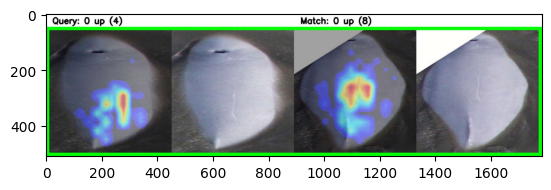

  0%|                                                                                                                                                                         | 0/849 [04:12<?, ?it/s]


In [161]:
# Iterate through instance-match pairs
idx_to_match_idxs = {idx:topk_idx[idx].tolist() for idx in range(len(images))}
for idx, match_idxs in tqdm(idx_to_match_idxs.items()):
    image0 = images[idx]
    for match in match_idxs:
        print(match)
        image1 = images[match]
        _vis_gradcam(idx, match, "up")
        break
    break